<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 699 non-null    int64 
 1   clump_thickness    699 non-null    int64 
 2   size_uniformity    699 non-null    int64 
 3   shape_uniformity   699 non-null    int64 
 4   marginal_adhesion  699 non-null    int64 
 5   epithelial_size    699 non-null    int64 
 6   bare_nucleoli      699 non-null    object
 7   bland_chromatin    699 non-null    int64 
 8   normal_nucleoli    699 non-null    int64 
 9   mitoses            699 non-null    int64 
 10  class              699 non-null    int64 
dtypes: int64(10), object(1)
memory usage: 60.2+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 699 non-n

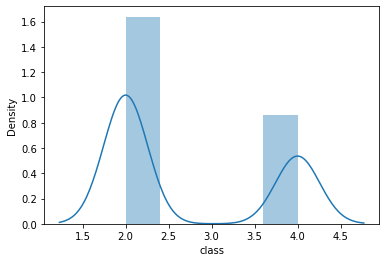

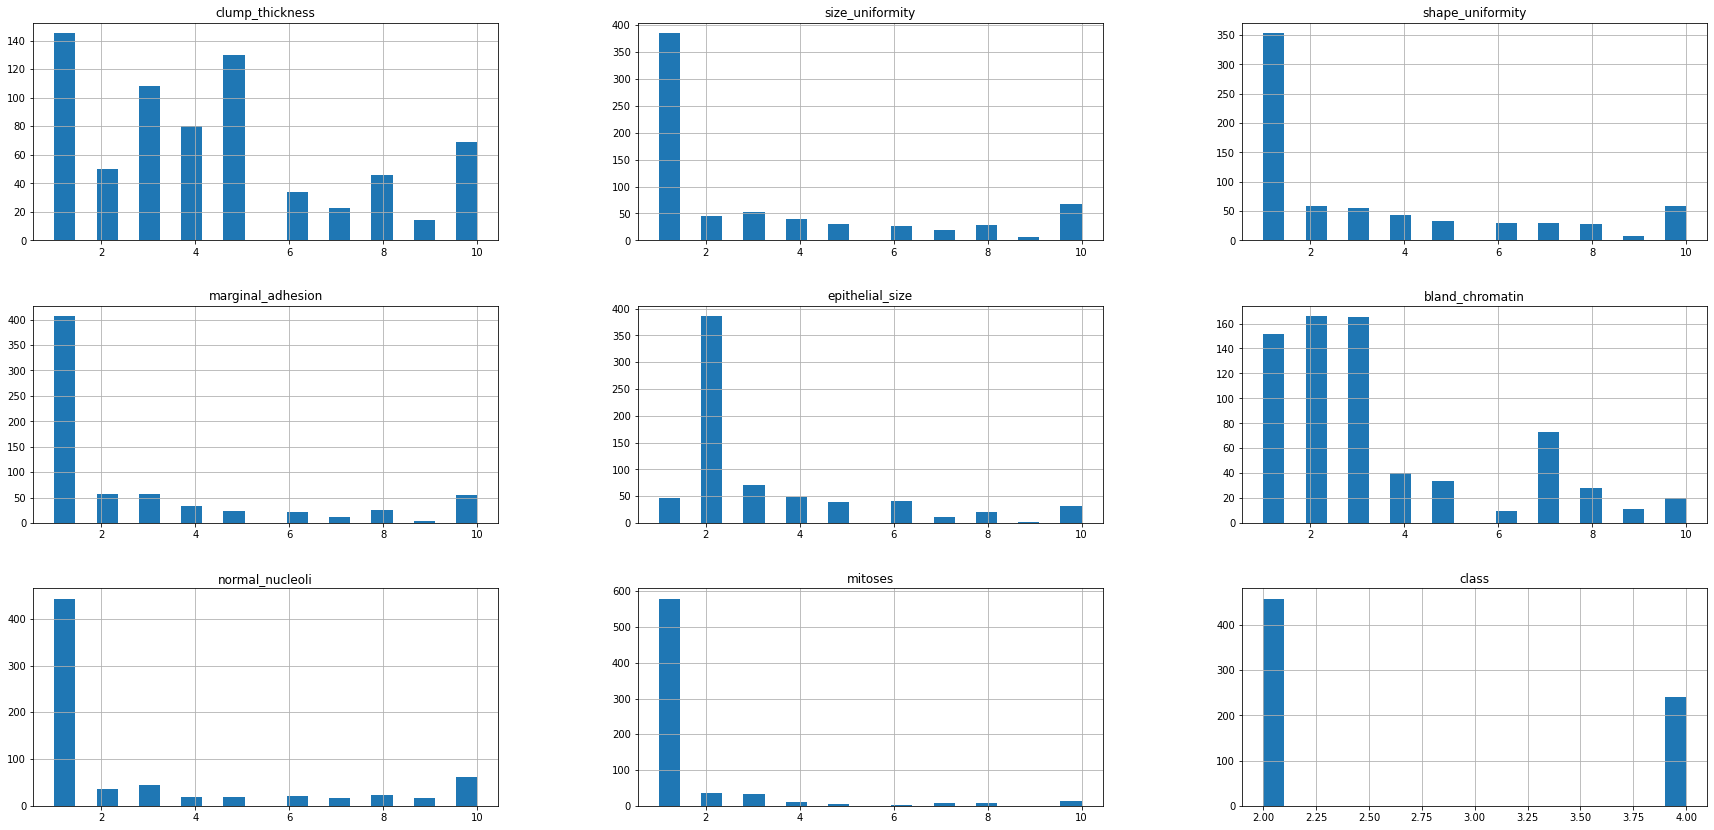

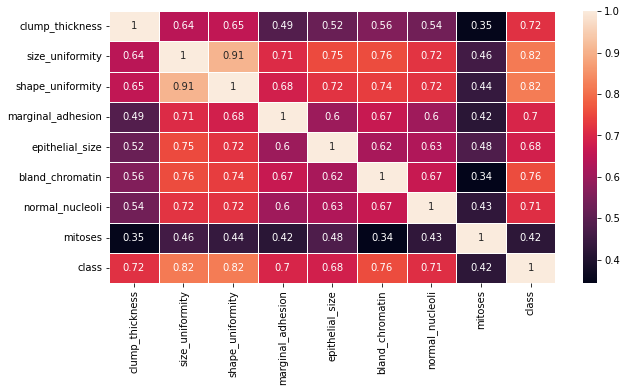

In [3]:
from sklearn import decomposition, datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, KFold


# Function for data preprocessing 
def preprocessing(dataset):
    
    df = pd.read_csv(dataset)
    
    # head method show only first 5 rows
    df.head()   

    # bare_nucleoli : object (Dtype)
    df.info()   

    df['bare_nucleoli'].value_counts()

    # replace dirty data to Nan
    df = df.replace('?', np.nan)    
    df.isnull().sum()

    # replace dirty data to median value
    df = df.fillna(df.median()) 

    # all feature Dtype : int64
    df.info()   

    # 'id' column has no meaning (obvious) -> drop
    df = df.drop('id', axis = 1)    

    # density of data by class
    sns.distplot(df['class'])   

    # data distribution by columns
    df.hist(bins=20, figsize=(30,30), layout=(6,3));    
    
    # correlation
    plt.figure(figsize = (10,5))    
    sns.heatmap(df.corr(), annot = True, linewidths = 0.5)
    
    # independent variables
    X = df.iloc[:,: -1] 
    
    # target ['class']
    y = df.iloc[:, -1]  

    # selectKBest for choosing the most related features
    selector = SelectKBest(score_func = chi2, k = 7)
    X_selected = selector.fit_transform(X, y)

    # list of selected features
    all_names = X.columns
    selected_mask = selector.get_support()
    selected_name = all_names[selected_mask]
    selected_name
    
    # train and test dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state = 2) 

    # drop the unselected features
    X = X[selected_name]

    # selectKBest for choosing the most related features
    selector = SelectKBest(score_func = chi2, k = 7)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)

    # list of selected features
    all_names = X_train.columns
    selected_mask = selector.get_support()
    selected_name = all_names[selected_mask]

    # drop the unselected features
    X_train = X_train[selected_name]
    X_test = X_test[selected_name]

    return X_train, X_test, y_train, y_test


# 4 types of algorithms, each has it's own hyperparameters
# get test scores for every algorithms 
def Algorithm(slr, X_train, X_test, y_train, y_test):

    # Scaler
    scaler = slr

    #===================== Logistic Regression =====================
    # print("===================== Logistic Regression =====================")
    algorithm = LogisticRegression()

    pipe = Pipeline(steps=[('scaler', scaler),
                            ('algorithm', algorithm )])

    C=[0.001, 0.01, 0.1, 1, 10, 25, 50, 100]
    max_iter=[50,100,150]
    solver=['newton-cg', 'lbfgs', 'liblinear']

    parameters = dict(
                    algorithm__C = C, 
                    algorithm__max_iter = max_iter, 
                    algorithm__solver = solver)

    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    clf_GS = GridSearchCV(pipe, parameters, cv=kfold).fit(X_train,y_train)

    scores_df = pd.DataFrame(clf_GS.cv_results_)
    

    # sort the dataframe by 'rank_test_score'
    log_top5 = scores_df.sort_values('rank_test_score')

    # To check the result
    # print()
    # print(log_top5)


    #===================== Entropy Classifier =====================
    # print("===================== Entropy Classifier =====================")
    algorithm = DecisionTreeClassifier()

    pipe = Pipeline(steps=[('scaler', scaler),
                            ('algorithm', algorithm)])

    criterion = ['entropy']
    max_depth = [2,4,6,8,10,12]
    min_samples_leaf = [1, 2, 5, 10]
    min_samples_split = [2, 5, 10, 15]
    max_features = ['auto', 'sqrt','log2']

    parameters = dict(
                    algorithm__criterion = criterion,
                    algorithm__max_depth = max_depth, 
                    algorithm__min_samples_leaf = min_samples_leaf, 
                    algorithm__min_samples_split = min_samples_split, 
                    algorithm__max_features = max_features)

    clf_GS = GridSearchCV(pipe, parameters, cv=3)
    clf_GS.fit(X_train, y_train)

    scores_df = pd.DataFrame(clf_GS.cv_results_)
 
    # sort the dataframe by 'rank_test_score'
    ent_top5 = scores_df.sort_values('rank_test_score')

    # To check the result   
    # print()
    # print(ent_top5)


    #===================== Gini Classifier =====================
    # print("===================== Gini Classifier =====================")
    algorithm = DecisionTreeClassifier()

    pipe = Pipeline(steps=[('scaler', scaler),
                            ('algorithm', algorithm)])

    criterion = ['gini']
    max_depth = [2,4,6,8,10,12]
    min_samples_leaf = [1, 2, 5, 10]
    min_samples_split = [2, 5, 10, 15]
    max_features = ['auto', 'sqrt','log2']

    parameters = dict(
                    algorithm__criterion = criterion,
                    algorithm__max_depth = max_depth, 
                    algorithm__min_samples_leaf = min_samples_leaf, 
                    algorithm__min_samples_split = min_samples_split, 
                    algorithm__max_features = max_features)

    clf_GS = GridSearchCV(pipe, parameters, cv=3)
    clf_GS.fit(X_train, y_train)

    scores_df = pd.DataFrame(clf_GS.cv_results_)
    
    # sort the dataframe by 'rank_test_score'
    gini_top5 = scores_df.sort_values('rank_test_score')

    # To check the result
    # print()
    # print(gini_top5)


    #===================== SVC =====================
    # print("===================== SVC =====================")
    algorithm = SVC()

    pipe = Pipeline(steps=[('scaler', scaler),
                            ('algorithm', algorithm )])

    C=[0.001, 0.01, 0.1, 1, 10, 25, 50, 100]
    kernel=['linear', 'sigmoid', 'rbf', 'poly']
    gamma=[0.001, 0.01, 0.1, 1, 10, 25, 50, 100]

    parameters = dict(
                    algorithm__C = C, 
                    algorithm__kernel = kernel, 
                    algorithm__gamma = gamma)

    clf_GS = GridSearchCV(pipe, parameters, cv=3)
    clf_GS.fit(X_train, y_train)

    scores_df = pd.DataFrame(clf_GS.cv_results_)
    
    # sort the dataframe by 'rank_test_score'
    svc_top5 = scores_df.sort_values('rank_test_score')

    # To check the result
    # print()
    # print(svc_top5)

    # concat every results from each algorithm
    al_top5 = pd.concat([log_top5, ent_top5, gini_top5, svc_top5])
    al_top5['Scaler'] = scaler
    al_top5 = al_top5.sort_values('mean_test_score', ascending=False)

    return al_top5

# 3 types of Scaler, each calls func Algorithm
def Scaling(X_train, X_test, y_train, y_test):

    top5_scaler_concat=pd.DataFrame()

    scaler = [MinMaxScaler(), StandardScaler(), RobustScaler()]
    for value in scaler:

        # Result of every algorithm for one scaler
        top5_scaler = Algorithm(value, X_train, X_test, y_train, y_test)

        # Result of every algorithm for every scaler
        top5_scaler_concat = pd.concat([top5_scaler_concat, top5_scaler])

    return top5_scaler_concat


# Function for calling func Scaling and return top 5 information
def modeling(X_train, X_test, y_train, y_test):

    # Receive the result of every algorithm for every scaler
    top5_cal = Scaling(X_train, X_test, y_train, y_test)

    top5_cal = pd.DataFrame(top5_cal)

    # sort and pick top 5 by 'mean_test_score'
    final_top5 = top5_cal.sort_values('mean_test_score', ascending=False).head(5)

    # pick only info needed (such as params and type of scaler)
    final_top5 = final_top5[['params', 'Scaler']]

    return final_top5.values.tolist()



# A function that receives a list of scaler and model and returns the top5 accuracy
def getBest5(dataset):

    X_train, X_test, y_train, y_test = preprocessing(dataset)

    top5 = []
    top5 = modeling(X_train, X_test, y_train, y_test)

    return top5



# user function call
# only need to check the dataset
dataset = 'breastCancer.csv'

print(getBest5(dataset))
